<a href="https://colab.research.google.com/github/FajarKKP/ML-DL_related_project/blob/main/SIBI_Transfer_Learning_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import sklearn

from sklearn.metrics import confusion_matrix, classification_report 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall, Accuracy, AUC

In [ ]:
# Install library that can help split dataset in folder
# pip install split-folders tqdm


Preprocess Dataset

In [6]:
#Import data from Gdrive
# data_dir = '/content/drive/MyDrive/Dataset_pakai'

# Initialize batch size and image size
batch_size = 32
image_size = (224,224)

In [ ]:
# import splitfolders
# splitfolders.ratio(data_dir, output="/content/drive/MyDrive/testing_folder", seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [7]:
# Get data from gdrive. Split and resize 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/testing_folder/train",
    labels = 'inferred',
    validation_split=0.2,
    subset="training",
    shuffle = True,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/testing_folder/val",
    labels = 'inferred',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/testing_folder/test",
    labels = 'inferred',
    image_size=image_size,
    batch_size=batch_size,
)

Found 9600 files belonging to 24 classes.
Using 7680 files for training.
Found 1200 files belonging to 24 classes.
Using 240 files for validation.
Found 1200 files belonging to 24 classes.


In [ ]:
class_names = train_dataset.class_names
print( "class_names: " + str( class_names ) )

In [ ]:
# # For Augmentation
# train_datagen = ImageDataGenerator(
#                     rescale=1./255,
#                     rotation_range=10,
#                     horizontal_flip=True)
 
# test_datagen = ImageDataGenerator(rescale=1./255,)

In [ ]:

# train_generator = train_datagen.flow_from_directory(
#         '/content/drive/MyDrive/testing_folder/train', 
#         target_size=image_size, 
#         batch_size=batch_size,
#         # shuffle = True,
#         class_mode='categorical')
 
# validation_generator = test_datagen.flow_from_directory(
#         '/content/drive/MyDrive/testing_folder/val', 
#         target_size=image_size, 
#         batch_size=batch_size,
#         # shuffle = True,
#         class_mode='categorical')

# test_generator = test_datagen.flow_from_directory(
#         '/content/drive/MyDrive/testing_folder/test', 
#         target_size=image_size, 
#         batch_size=batch_size,
#         class_mode='categorical')

In [9]:
# Input Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
        #layers.Rescaling(scale = 1./255)
    ]
)

In [10]:
# Augment the train and validation dataset
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

augmented_val_ds = val_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

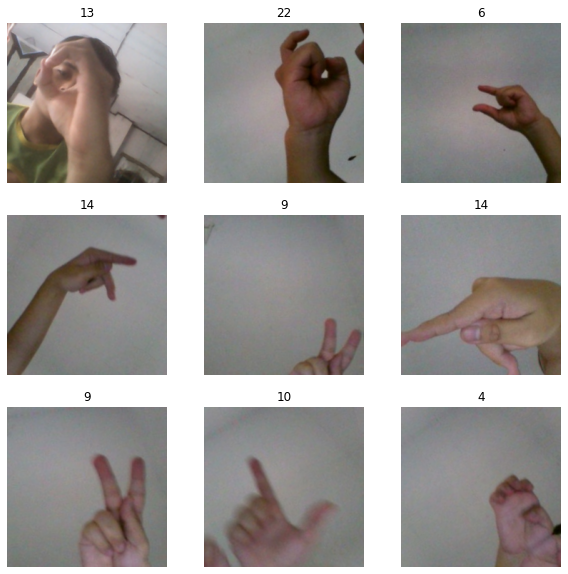

In [ ]:
# Example of dataset that has been augmented
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

The Model

In [ ]:
# Import the EfficientNet model
eff_model1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=(224,224,3))
print(type(eff_model1))
eff_model1.summary()

<class 'keras.engine.functional.Functional'>
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 2

In [ ]:
# Freeze the EfficientNet, then set the dropout rate we will use for our model
eff_model1.trainable = False
dropout_rate = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

In [ ]:
# Create a new model, combining the EfficientNet and new output layer with 24 output class

model = models.Sequential()
model.add(eff_model1)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))

model.add(layers.Dense(24, activation="softmax", name="fc_out"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 24)                30744     
                                                                 
Total params: 4,080,315
Trainable params: 30,744
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Train model
epochs = 50

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\n Good enough, its above 98%")
      self.model.stop_training=True
callbacks = myCallback()

# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="accuracy",
#     patience=5,
  
# )


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy", #"sparse_categorical_crossentropy" if label is in integer
    metrics=['accuracy'],
)
final_model = model.fit(train_ds, epochs=epochs, callbacks=[callbacks], validation_data=val_ds)

Epoch 1/50
240/240 [==============================] - 363s 1s/step - loss: 2.2520 - accuracy: 0.5355 - val_loss: 0.6654 - val_accuracy: 0.8000
Epoch 2/50
240/240 [==============================] - 386s 2s/step - loss: 0.5452 - accuracy: 0.8368 - val_loss: 0.2112 - val_accuracy: 0.9375
Epoch 3/50
240/240 [==============================] - 371s 2s/step - loss: 0.3219 - accuracy: 0.9034 - val_loss: 0.1623 - val_accuracy: 0.9375
Epoch 4/50
240/240 [==============================] - 397s 2s/step - loss: 0.2248 - accuracy: 0.9315 - val_loss: 0.0737 - val_accuracy: 0.9875
Epoch 5/50
240/240 [==============================] - 369s 2s/step - loss: 0.1665 - accuracy: 0.9452 - val_loss: 0.0476 - val_accuracy: 0.9833
Epoch 6/50
240/240 [==============================] - 377s 2s/step - loss: 0.1448 - accuracy: 0.9543 - val_loss: 0.0556 - val_accuracy: 0.9750
Epoch 7/50
240/240 [==============================] - 385s 2s/step - loss: 0.1254 - accuracy: 0.9604 - val_loss: 0.0277 - val_accuracy: 0.9958

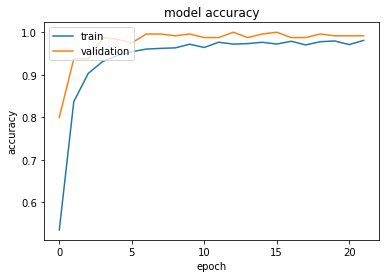

In [ ]:
def plot_hist(final_model):
    plt.plot(final_model.history["accuracy"])
    plt.plot(final_model.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(final_model)

In [ ]:
# Confusion Matrix

In [ ]:
model.save('/content/drive/MyDrive/Hasil_model_EfficientNet/final_modelv3.h5')
model.save('/content/drive/MyDrive/Hasil_model_EfficientNet/final_modelv3.hdf5')

In [3]:
# # load model that has been trained
model_done = keras.models.load_model("/content/drive/MyDrive/Hasil_model_EfficientNet/final_modelv3.h5")

In [11]:
results = model_done.evaluate(test_ds, verbose = 2)

38/38 - 334s - loss: 0.0197 - accuracy: 0.9950 - 334s/epoch - 9s/step


In [ ]:
# y_pred = model.predict(test_ds)